# This Notebook presents an expriment of Theory Of Mind on Rock Paper Scissors
### The goal is to research and devlop a method for generic multi-agent games using Theory of Mind modeling.
### We will introduce the tradeoff between choosing optimal move and staying unpredictable.

In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization

## The model of agent as universal Probalistic Model
### gets some parmeters:
<ul>
    <li> opponent agent - representation of our belief on the opponent model (Turing.jl model)
    <li> my history - list of all moves this player done (At this point unused)
    <li> opponent history - list of all moves the opponent done, used to estimate a prior on the moves
    <li> depth - the depth we want the agent will dive modeling the mind of opponent agent
</ul>        

In [2]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [18]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [15]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == 0
        for opp_move in opponent_history
            opp_move ~ Categorical(beta_opp) # observe
        end
    end
    next_opp_move ~ Categorical(beta_opp) # sample
    opp_move_sample = next_opp_move
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:next_opp_move][idx, 1]
    end
     # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[winning(next_opp_move)] = PDIRAC
    
    my_move = winning(opp_move_sample)
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

the infece is about the opponent model and not my model

In [16]:
# Plot the results
function plotChn(chn)
    histogram(chn[:next_opp_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [17]:
function run_two_agents_theory_of_mind(first_model, second_model, first_player_history, second_player_history ,depth)
    second_chn_i = []
    for i in 0:depth
        first_chn_i = sample(first_model(second_chn_i, second_player_history, PRIOR_POLICY, i),  INFALG, N)
        second_chn_i = sample(second_model(first_chn_i, first_player_history, PRIOR_POLICY, i), INFALG, N)
    end
    display(second_chn_i)
    plotChn(second_chn_i)
end

run_two_agents_theory_of_mind (generic function with 1 method)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], infered_opponent_move, next_opp_move, opp_move
internals         = lp

Summary Statistics
             parameters      mean       std   naive_se      mcse         ess   ⋯
                 Symbol   Float64   Float64    Float64   Float64     Float64   ⋯

            beta_opp[1]    0.3300    0.2361     0.0024    0.0025   9971.0343   ⋯
            beta_opp[2]    0.3352    0.2354     0.0024    0.0022   9988.4290   ⋯
            beta_opp[3]    0.3349    0.2341     0.0023    0.0024   9389.7149   ⋯
  infered_opponent_move    2.0055    0.8165     0.0082    0.0080   9922.8460   ⋯
          next_opp_move    2.0030    0.8169     0.0082    0.0081   9765.9251   ⋯
               opp_move    2.0082    0.8139     0.0081    0.0086   9831.7318   ⋯
                               

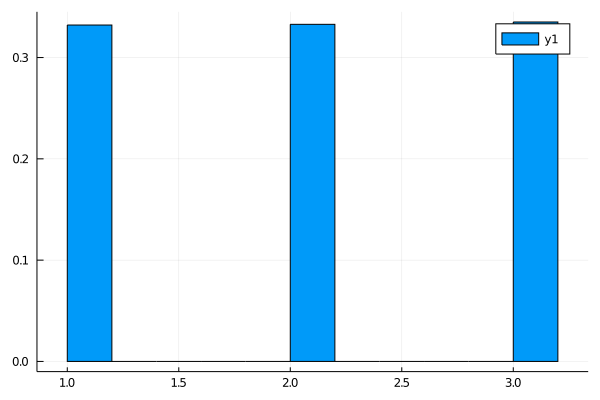

In [14]:
run_two_agents_theory_of_mind(agent, agent, [1,3,1,3,1,1,3,1,3,1] , [2,2,2,1,1], 0)

### This method is used for the simulation, each model make a move at the end of this function, as a result of reasoning of the model

In [8]:
function move(agent, other_agent, other_agent_history, other_player_prior, my_depth=1)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    m = agent(other_agent, other_agent_history, other_player_prior, my_depth)
    chain = memoized_sample(m, IS(), 10)
    moves = generated_quantities(m, chain)
    return most_common(moves)
end

move (generic function with 2 methods)

### Game simulation , given two agent models , depth params, let them play num of simulation times

In [9]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1])
    first_player = agent
    second_player = agent
#     first_player_prior_policy = [1, 1, 1]
#     second_player_prior_policy = [1, 1, 1]
    num_of_simulations = 10
    first_player_history = []
    second_player_history = []
    for i in 1:num_of_simulations
        m1 = move(first_player, second_player, second_player_history, second_player_prior_policy, first_player_depth)
        push!(first_player_history, m1)
        m2 = move(second_player, first_player, first_player_history, first_player_prior_policy, second_player_depth)
        push!(second_player_history, m2)
    end
    return first_player_history, second_player_history
 end

game (generic function with 5 methods)

In [10]:
function score(history)
    first_player_history, second_player_history = history
    first_wins = 0
    ties = 0
    second_wins = 0
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
    end
    return first_wins, ties, second_wins
end

score (generic function with 1 method)

In [11]:
score([[1, 2], [3, 1]])

(0, 0, 2)

In [12]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

both player plays without theory of mind - equivilent

In [13]:
display_score(score(game(0, 0)))

first player won: 4
second player won: 2
ties: 4


2nd player plays with one level of theory of mind -> 2nd wins

In [14]:
display_score(score(game(0, 1)))

first player won: 1
second player won: 5
ties: 4


In [15]:
display_score(score(game(0, 1)))

first player won: 2
second player won: 3
ties: 5


1st player plays with one level of theory of mind -> 1st wins

In [16]:
@time begin
    display_score(score(game(1, 0)))
end

first player won: 5
second player won: 2
ties: 3
  3.282614 seconds (14.52 M allocations: 870.918 MiB, 6.97% gc time)


In [17]:
display_score(score(game(1, 0)))

first player won: 4
second player won: 4
ties: 2


both players play with one level of theory of mind -> preety much equivelent

In [18]:
@time begin
    display_score(score(game(1, 1)))
end

first player won: 2
second player won: 5
ties: 3
  8.170849 seconds (29.21 M allocations: 1.708 GiB, 7.05% gc time)


In [19]:
@time begin
    display_score(score(game(1, 1)))
end

first player won: 3
second player won: 5
ties: 2
  6.871379 seconds (29.21 M allocations: 1.708 GiB, 7.74% gc time)


In [20]:
@time begin
    display_score(score(game(0, 2)))
end

first player won: 2
second player won: 4
ties: 4
528.307919 seconds (2.97 G allocations: 173.272 GiB, 6.60% gc time)


In [21]:
display_score(score(game(0, 2)))

first player won: 3
second player won: 2
ties: 5


In [22]:
@time begin
    display_score(score(game(2, 0)))
end

first player won: 3
second player won: 5
ties: 2
578.851981 seconds (2.90 G allocations: 170.019 GiB, 5.99% gc time)


In [23]:
@time begin
    display_score(score(game(2, 0)))
end

first player won: 5
second player won: 1
ties: 4
536.764620 seconds (2.90 G allocations: 170.019 GiB, 6.23% gc time)


In [24]:
@time begin
    display_score(score(game(1, 2)))
end

first player won: 2
second player won: 5
ties: 3
583.566516 seconds (2.98 G allocations: 174.112 GiB, 6.15% gc time)


In [25]:
@time begin
    display_score(score(game(1, 2)))
end

first player won: 1
second player won: 7
ties: 2
600.915717 seconds (2.98 G allocations: 174.120 GiB, 6.70% gc time)


In [26]:
@time begin
    display_score(score(game(2, 1)))
end

first player won: 1
second player won: 4
ties: 5
495.320000 seconds (2.92 G allocations: 170.877 GiB, 6.24% gc time)


In [27]:
display_score(score(game(2, 1)))

first player won: 5
second player won: 2
ties: 3


In [28]:
@time begin
    display_score(score(game(2, 2)))
end

first player won: 3
second player won: 4
ties: 3
1050.767540 seconds (5.87 G allocations: 343.281 GiB, 10.05% gc time)


In [ ]:
@time begin 
    display_score(score(game(0, 3)))
end

In [ ]:
@time begin
    display_score(score(game(3, 0)))
end

In [ ]:
display_score(score(game(0, 0, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(0, 0, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(0, 1, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(0, 1, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(1, 0, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(1, 0, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(1, 1, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(1, 1, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(0, 0,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(0, 0,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(0, 1,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(0, 1,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(1, 0,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(1, 0,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(1, 1,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(1, 1,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(0, 2,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(0, 2,[20,1,1], [1,1,1])))

In [ ]:
display_score(score(game(2, 0,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(2, 0, [20,1,1],[1,1,1])))

In [ ]:
display_score(score(game(1, 2, [20,1,1] ,[1,1,1])))

In [ ]:
display_score(score(game(1, 2,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(2, 1, [20,1,1] ,[1,1,1])))

In [ ]:
display_score(score(game(2, 1 ,[1,1,1], [20,1,1])))

In [ ]:
display_score(score(game(2, 2, [20,1,1] ,[1,1,1])))

In [ ]:
display_score(score(game(2, 2, [1,1,1], [20,1,1])))

In [ ]:
@time begin
    display_score(score(game(4, 0)))
end

In [ ]:
@time begin
    display_score(score(game(0, 4)))
end

In [ ]:
@time begin
    display_score(score(game(5, 0)))
end

In [ ]:
@time begin
    display_score(score(game(0, 5)))
end

In [ ]:
@time begin
    display_score(score(game(5, 4)))
end

In [ ]:
@time begin
    display_score(score(game(6, 0)))
end